In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that

# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME


Mounted at /content/drive
/content/drive/My Drive/cs231n/project


# Initial Setup

In [2]:
# As usual, a bit of setup

%cd code

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from utils import *

%cd ..
!ls

/content/drive/My Drive/cs231n/project/code
/content/drive/My Drive/cs231n/project
cnn_vgg_19.ipynb	cnn_vgg_19_old_3.ipynb	code
cnn_vgg_19_old_2.ipynb	cnn_vgg_19_old.ipynb


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 29 17:27:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Create CNN - VGG-19

In [5]:
# Define the model
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process)
    """
    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D
    Z1 = tf.keras.layers.Conv2D(64, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(input_img)
    A1 = tf.keras.layers.ReLU()(Z1)
    B1 = tf.keras.layers.BatchNormalization()(A1)
    Z2 = tf.keras.layers.Conv2D(64, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B1)
    A2 = tf.keras.layers.ReLU()(Z2)
    B2 = tf.keras.layers.BatchNormalization()(A2)
    P1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(B2)
    ## CONV2D
    Z3 = tf.keras.layers.Conv2D(128, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(P1)
    A3 = tf.keras.layers.ReLU()(Z3)
    B3 = tf.keras.layers.BatchNormalization()(A3)
    Z4 = tf.keras.layers.Conv2D(128, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B3)
    A4 = tf.keras.layers.ReLU()(Z4)
    B4 = tf.keras.layers.BatchNormalization()(A4)
    P2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(B4)
    ## CONV2D
    Z5 = tf.keras.layers.Conv2D(256, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(P2)
    A5 = tf.keras.layers.ReLU()(Z5)
    B5 = tf.keras.layers.BatchNormalization()(A5)
    Z6 = tf.keras.layers.Conv2D(256, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B5)
    A6 = tf.keras.layers.ReLU()(Z6)
    B6 = tf.keras.layers.BatchNormalization()(A6)
    Z7 = tf.keras.layers.Conv2D(256, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B6)
    A7 = tf.keras.layers.ReLU()(Z7)
    B7 = tf.keras.layers.BatchNormalization()(A7)
    P3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(B7)
    ## CONV2D
    Z8 = tf.keras.layers.Conv2D(512, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(P3)
    A8 = tf.keras.layers.ReLU()(Z8)
    B8 = tf.keras.layers.BatchNormalization()(A8)
    Z9 = tf.keras.layers.Conv2D(512, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B8)
    A9 = tf.keras.layers.ReLU()(Z9)
    B9 = tf.keras.layers.BatchNormalization()(A9)
    Z10 = tf.keras.layers.Conv2D(512, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B9)
    A10 = tf.keras.layers.ReLU()(Z10)
    B10 = tf.keras.layers.BatchNormalization()(A10)
    Z11 = tf.keras.layers.Conv2D(512, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B10)
    A11 = tf.keras.layers.ReLU()(Z11)
    B11 = tf.keras.layers.BatchNormalization()(A11)
    P4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(B11)
    ## CONV2D
    Z12 = tf.keras.layers.Conv2D(512, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(P4)
    A12 = tf.keras.layers.ReLU()(Z12)
    B12 = tf.keras.layers.BatchNormalization()(A12)
    Z13 = tf.keras.layers.Conv2D(512, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B12)
    A13 = tf.keras.layers.ReLU()(Z13)
    B13 = tf.keras.layers.BatchNormalization()(A13)
    Z14 = tf.keras.layers.Conv2D(512, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B13)
    A14 = tf.keras.layers.ReLU()(Z14)
    B14 = tf.keras.layers.BatchNormalization()(A14)
    Z15 = tf.keras.layers.Conv2D(512, (3, 3), padding='SAME',
                                kernel_initializer=tf.keras.initializers.he_uniform(),
                                bias_initializer=tf.zeros_initializer())(B14)
    A15 = tf.keras.layers.ReLU()(Z15)
    B15 = tf.keras.layers.BatchNormalization()(A15)
    P5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(B15)
    ## FLATTEN
    F = tf.keras.layers.Flatten()(P5)
    ## Dense layers
    D1 = tf.keras.layers.Dense(4096, activation=activations.relu)(F)
    D01 = tf.keras.layers.Dropout(0.5)(D1)
    D2 = tf.keras.layers.Dense(4096, activation=activations.relu)(D01)
    D02 = tf.keras.layers.Dropout(0.5)(D2)
    ## 7 neurons in output layer. Hint: one of the arguments should be "activation='softmax'"
    outputs = tf.keras.layers.Dense(7, activation='softmax')(D02)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

# Testing the mean values

In [ ]:
img1 = np.ones((1,224,224,3))
img2 = np.zeros((1,224,224,3))
img3 = np.ones((1,224,224,3))
img4 = np.ones((1,224,224,3))
values = np.vstack([img1, img2, img3, img4])
N = values.shape[0]
means = np.sum(values, axis=0) / N
mean = np.mean(values)
print((img2 - means)[0].shape)
print(mean)

(224, 224, 3)
0.75


# Load the dataset

In [6]:
# Loading the data 
%cd code
orig_x, orig_y = read_data()
orig_y = classification(orig_y, orig_y)
orig_y = one_hot_labels(orig_y)
# orig_x = orig_x / 255.
orig_x = orig_x-np.mean(orig_x)
# Create the training sample
train_x, val_test_x, train_y, val_test_y = train_test_split(orig_x, orig_y, test_size=0.3, random_state=1)
# Split the remaining observations into validation and test
val_x, test_x, val_y, test_y = train_test_split(val_test_x, val_test_y, test_size=0.4, random_state=1)
%cd ..

/content/drive/MyDrive/cs231n/project/code
/content/drive/My Drive/cs231n/project/code/images
(1, 500, 500, 3)
(2, 500, 500, 3)
(3, 500, 500, 3)
(4, 500, 500, 3)
(5, 500, 500, 3)
(6, 500, 500, 3)
(7, 500, 500, 3)
(8, 500, 500, 3)
(9, 500, 500, 3)
(10, 500, 500, 3)
(11, 500, 500, 3)
(12, 500, 500, 3)
(13, 500, 500, 3)
(14, 500, 500, 3)
(15, 500, 500, 3)
(16, 500, 500, 3)
(17, 500, 500, 3)
(18, 500, 500, 3)
(19, 500, 500, 3)
(20, 500, 500, 3)
(21, 500, 500, 3)
(22, 500, 500, 3)
(23, 500, 500, 3)
(24, 500, 500, 3)
(25, 500, 500, 3)
(26, 500, 500, 3)
(27, 500, 500, 3)
(28, 500, 500, 3)
(29, 500, 500, 3)
(30, 500, 500, 3)
(31, 500, 500, 3)
(32, 500, 500, 3)
(33, 500, 500, 3)
(34, 500, 500, 3)
(35, 500, 500, 3)
(36, 500, 500, 3)
(37, 500, 500, 3)
(38, 500, 500, 3)
(39, 500, 500, 3)
(40, 500, 500, 3)
(41, 500, 500, 3)
(42, 500, 500, 3)
(43, 500, 500, 3)
(44, 500, 500, 3)
(45, 500, 500, 3)
(46, 500, 500, 3)
(47, 500, 500, 3)
(48, 500, 500, 3)
(49, 500, 500, 3)
(50, 500, 500, 3)
(51, 500, 500, 

# Check the dataset

In [7]:
# Example of an image from the dataset
#index = 270
#plt.imshow(orig_x[index])
#print(orig_x[index])

print("number of training examples = " + str(train_x.shape[0]))
print("number of validation examples = " + str(val_x.shape[0]))
print("X_train shape: " + str(train_x.shape))
print("Y_train shape: " + str(train_y.shape))
print("X_val shape: " + str(val_x.shape))
print("Y_val shape: " + str(val_y.shape))
print("X_test shape: " + str(test_x.shape))
print("Y_test shape: " + str(test_y.shape))

number of training examples = 637
number of validation examples = 163
X_train shape: (637, 500, 500, 3)
Y_train shape: (637, 7)
X_val shape: (163, 500, 500, 3)
Y_val shape: (163, 7)
X_test shape: (110, 500, 500, 3)
Y_test shape: (110, 7)


# Create the model - using tensorflow

In [8]:
from tensorflow.python.eager.context import set_log_device_placement
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

# Create the model
conv_model = convolutional_model((224, 224, 3))
# Establishes an exponential decay
lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=640,
    decay_rate=0.75
)
# Define an Adam optimizer
#adam = tfa.optimizers.AdamW(weight_decay=5e-4, learning_rate=lr_schedule)
#adam = tf.optimizers.Adam(learning_rate=lr_schedule)
sgd = tf.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
# Compile the model
conv_model.compile(optimizer=sgd,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
conv_model.summary()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.8 MB/s 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 re_lu (ReLU)                (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                     

In [10]:
# Create the image generator
datagen = ImageDataGenerator(featurewise_std_normalization=True)
train_batches = datagen.flow(train_x, train_y, batch_size=64)
train_crops = crop_generator(train_batches, 224)
val_batches = datagen.flow(val_x, val_y, batch_size=64)
val_crops = crop_generator(val_batches, 224)
test_batches = datagen.flow(test_x, test_y, batch_size=1, shuffle=False)
test_crops = crop_generator(test_batches, 224)

history = conv_model.fit_generator(train_crops, epochs=400, steps_per_epoch=64,
                                       validation_data=val_crops, validation_steps=64)

print(history.history)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_s

Epoch 1/400
64/64 [==============================] - 56s 872ms/step - loss: 2.7489 - accuracy: 0.3131 - val_loss: 172.6744 - val_accuracy: 0.0310
Epoch 2/400
64/64 [==============================] - 44s 688ms/step - loss: 1.6637 - accuracy: 0.4112 - val_loss: 24.5194 - val_accuracy: 0.1732
Epoch 3/400
64/64 [==============================] - 44s 688ms/step - loss: 1.4854 - accuracy: 0.4444 - val_loss: 4.1601 - val_accuracy: 0.2243
Epoch 4/400
64/64 [==============================] - 44s 690ms/step - loss: 1.3563 - accuracy: 0.4811 - val_loss: 1.8181 - val_accuracy: 0.4316
Epoch 5/400
64/64 [==============================] - 44s 687ms/step - loss: 1.2149 - accuracy: 0.5345 - val_loss: 1.5415 - val_accuracy: 0.3820
Epoch 6/400
64/64 [==============================] - 44s 690ms/step - loss: 1.1404 - accuracy: 0.5535 - val_loss: 1.3320 - val_accuracy: 0.4864
Epoch 7/400
64/64 [==============================] - 44s 692ms/step - loss: 1.0456 - accuracy: 0.5866 - val_loss: 1.2994 - val_accura

# Train the model

# Plot history

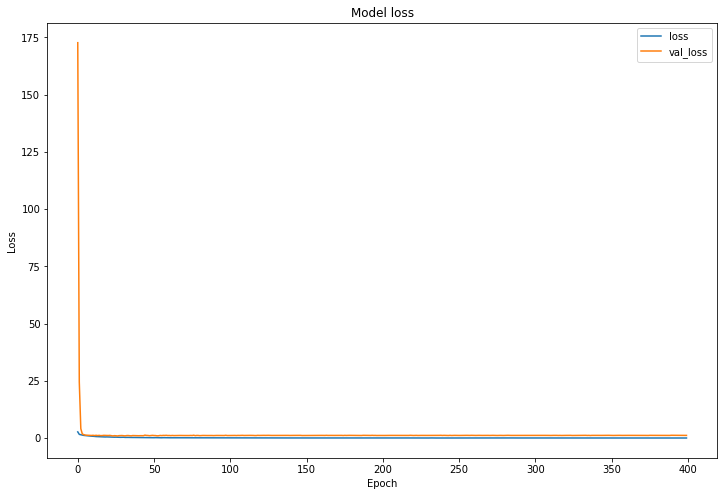

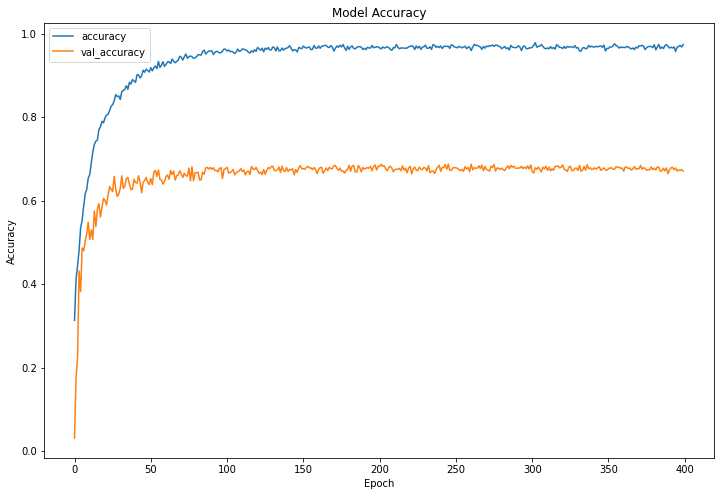

In [11]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[['loss', 'val_loss']]
df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_loss.plot(title='Model loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

# Test the model

In [12]:
temp_x, y = [], []
x = np.empty((1000, 224, 224, 3))
for i in range(1000):
    a, b = test_crops.__next__()
    temp_x.extend(a)
    x[i,] = a
    y.extend(b)
print(x.shape)
Pred_y = conv_model.predict(x)
pred_y = np.argmax(Pred_y, axis=1)
Test_y = np.array(y)
test_y = np.argmax(Test_y, axis=1)
print(test_y)
print('pred_y')
print(pred_y)
# Calculate accuracy, precision, recall and confusion matrix
print('Test Accuracy: ', accuracy_score(test_y, pred_y))
print('Test Precision: ', precision_score(test_y, pred_y, zero_division=0, average='weighted'))
print('Test Recall: ', recall_score(test_y, pred_y, average='weighted'))
print('Test f1', f1_score(test_y, pred_y, zero_division=0, average='weighted', labels=np.unique(pred_y)))


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(1000, 224, 224, 3)
[2 0 3 1 0 2 2 2 4 3 2 3 2 2 6 2 3 1 0 3 1 3 3 4 2 3 3 0 4 1 2 3 0 0 4 1 2
 4 2 2 4 2 1 4 1 6 1 6 3 3 3 4 4 4 0 1 3 2 3 4 4 5 4 3 1 4 0 4 0 1 0 1 1 0
 1 3 2 4 3 1 1 2 3 1 1 1 1 4 0 2 1 3 1 6 2 0 4 1 6 2 3 2 1 3 2 3 5 1 1 2 2
 0 3 1 0 2 2 2 4 3 2 3 2 2 6 2 3 1 0 3 1 3 3 4 2 3 3 0 4 1 2 3 0 0 4 1 2 4
 2 2 4 2 1 4 1 6 1 6 3 3 3 4 4 4 0 1 3 2 3 4 4 5 4 3 1 4 0 4 0 1 0 1 1 0 1
 3 2 4 3 1 1 2 3 1 1 1 1 4 0 2 1 3 1 6 2 0 4 1 6 2 3 2 1 3 2 3 5 1 1 2 2 0
 3 1 0 2 2 2 4 3 2 3 2 2 6 2 3 1 0 3 1 3 3 4 2 3 3 0 4 1 2 3 0 0 4 1 2 4 2
 2 4 2 1 4 1 6 1 6 3 3 3 4 4 4 0 1 3 2 3 4 4 5 4 3 1 4 0 4 0 1 0 1 1 0 1 3
 2 4 3 1 1 2 3 1 1 1 1 4 0 2 1 3 1 6 2 0 4 1 6 2 3 2 1 3 2 3 5 1 1 2 2 0 3
 1 0 2 2 2 4 3 2 3 2 2 6 2 3 1 0 3 1 3 3 4 2 3 3 0 4 1 2 3 0 0 4 1 2 4 2 2
 4 2 1 4 1 6 1 6 3 3 3 4 4 4 0 1 3 2 3 4 4 5 4 3 1 4 0 4 0 1 0 1 1 0 1 3 2
 4 3 1 1 2 3 1 1 1 1 4 0 2 1 3 1 6 2 0 4 1 6 2 3 2 1 3 2 3 5 1 1 2 2 0 3 1
 0 2 2 2 4 3 2 3 2 2 6 2 3 1 0 3 1 3 3 4 2 3 3 0 4 1 2 3 0 0 4 1 2 4 2 2 4
 2 1 

# Confusion Matrix

Confusion Matrix
[[ 98   5   2  12   1   1   0]
 [ 16 207  11   1   0   0   0]
 [  4  36 106  48  17   0   0]
 [  0   5  20 145  39   0   0]
 [  2   0   5  19 132   5   0]
 [  1   0   3   6   1   7   0]
 [  0   0   5   5   1   0  34]]


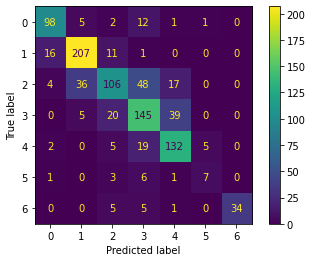

In [13]:
cm = confusion_matrix(test_y, pred_y)
print('Confusion Matrix')
print(cm)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

# Calculate the scores

In [14]:
scores = conv_model.evaluate(test_crops, steps=1000)
print(scores)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1000/1000 [==============================] - 13s 13ms/step - loss: 1.1925 - accuracy: 0.7260
[1.1924827098846436, 0.7260000109672546]
